In [ ]:
#!/usr/bin/env python3
"""
MF-NPE using precomputed training data with robust weight transfer
- UPGRADED with a more robust fine-tuning strategy to match the thesis methodology.
- This version uses early stopping and a validation set.
"""

import time
import pathlib
import torch
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from sbi.inference import SNPE
from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from mf_npe.simulator.high_fidelity_hh import MarkovHHSimulator
from mf_npe.simulator.low_fidelity_hh import NoisyHHSimulator

/var/autofs/misc/home/petera/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **$MF-NPE5_{1000}$**

Loading LF data from mf_npe_demo/mf-npe5(1000)/lf_training_data_100000.pt
  LF: θ shape (100000, 3), x shape (100000, 4)
Loading HF data from mf_npe_demo/mf-npe5(1000)/hf_training_data_1000.pt
  HF: θ shape (1000, 3), x shape (1000, 4)
Training LF SNPE...


/tmp/ipykernel_3516969/1922516508.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_dict = torch.load(LF_PATH, map_location=device)
/tmp/ipykernel_3516969/1922516508.p

 Neural network successfully converged after 94 epochs.LF SNPE done.
Computing LF summaries at HF thetas via JAX...
Setting up MF SNPE and transferring matching LF weights…
Fine-tuning MF SNPE with early stopping and regularization...
 Neural network successfully converged after 150 epochs.MF SNPE done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
Computing LF summary for the observed data...
  Created and saved MF observation with shape: torch.Size([1, 8])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5138it [00:00, 137902.72it/s]                   

NLTP at truth: 7.264
MAP: [131.1998      34.914146     0.38924927], mean: [133.67944     35.504177     0.39640185], std: [31.094152    6.7068777   0.09609479]
Generating plots...



/tmp/ipykernel_3516969/1922516508.py:150: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.


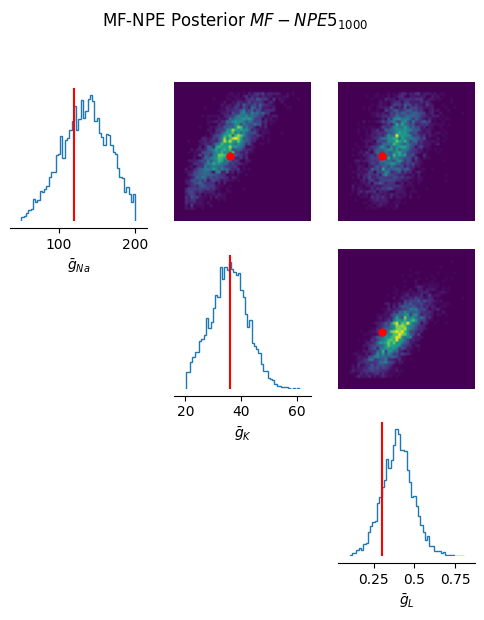

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
jax_key = jax.random.PRNGKey(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OBS_PATH = pathlib.Path("outputs/single_hf_trace/markov_ground_truth_trace.npz")
LF_PATH = pathlib.Path("outputs/mf_npe_5_1000/training_data/lf_training_data_100000.pt")
HF_PATH = pathlib.Path("outputs/mf_npe_5_1000/training_data/hf_training_data_1000.pt")
SAVE_DIR = pathlib.Path("outputs/mf_npe_5_1000")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR & SUMMARY
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

@jax.jit
def summarize_voltage_jax(t, V):
    crossings = jnp.sum((V[:-1] < 0) & (V[1:] >= 0))
    rest_mask = t < 10.0
    stim_mask = (t >= 10.0) & (t < 30.0)
    n_rest = jnp.sum(rest_mask)
    mean_rest = jnp.sum(V * rest_mask) / n_rest
    var_rest = jnp.sum((V**2) * rest_mask) / n_rest - mean_rest**2
    std_rest = jnp.sqrt(jnp.maximum(var_rest, 0.0))
    mean_stim = jnp.sum(V * stim_mask) / jnp.sum(stim_mask)
    return jnp.stack([crossings, mean_rest, std_rest, mean_stim])

@jax.jit
@jax.vmap
def simulate_lf_jax(key, th):
    t, V, *_ = hh_current_noise(key=key, gbar_Na=th[0], gbar_K=th[1], gbar_L=th[2])
    return summarize_voltage_jax(t, V)

# ----------------------------------------------------------------------------
# LOAD LF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading LF data from", LF_PATH)
lf_dict = torch.load(LF_PATH, map_location=device)
theta_lf = lf_dict.get("theta_train", lf_dict.get("theta"))
x_lf = lf_dict.get("x_train", lf_dict.get("x"))
print(f"  LF: θ shape {tuple(theta_lf.shape)}, x shape {tuple(x_lf.shape)}")

# ----------------------------------------------------------------------------
# LOAD HF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)
theta_hf_t = hf_dict.get("theta_hf", hf_dict.get("theta"))
x_hf_t = hf_dict.get("x_hf", hf_dict.get("x"))
print(f"  HF: θ shape {tuple(theta_hf_t.shape)}, x shape {tuple(x_hf_t.shape)}")

# ----------------------------------------------------------------------------
# TRAIN LOW-FIDELITY SNPE
# ----------------------------------------------------------------------------
print("Training LF SNPE...")
inference_lf = SNPE(prior=prior, density_estimator="maf", device=device)
de_lf = inference_lf.append_simulations(theta_lf, x_lf)
density_estimator_lf = de_lf.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=512,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_lf = inference_lf.build_posterior(density_estimator_lf)
torch.save(posterior_lf, SAVE_DIR / "lf_de.pkl")
print("LF SNPE done.")

# ----------------------------------------------------------------------------
# TRAIN MULTI-FIDELITY SNPE (LF→HF) with ROBUST FINE-TUNING
# ----------------------------------------------------------------------------
print("Computing LF summaries at HF thetas via JAX...")
theta_hf_np = theta_hf_t.cpu().numpy()
key, jax_key = jax.random.split(jax_key)
hf_keys = jax.random.split(key, theta_hf_np.shape[0])
x_lf_at_hf = np.array(simulate_lf_jax(hf_keys, jnp.array(theta_hf_np)))
x_lf_at_hf_t = torch.from_numpy(x_lf_at_hf).float()

print("Setting up MF SNPE and transferring matching LF weights…")
inference_mf = SNPE(prior=prior, density_estimator="maf", device=device)
x_mf_t = torch.cat([x_lf_at_hf_t, x_hf_t], dim=1)
de_mf = inference_mf.append_simulations(theta_hf_t, x_mf_t)
density_estimator_mf = de_mf._build_neural_net(theta_hf_t, x_mf_t)
lf_state = density_estimator_lf.state_dict()
mf_state = density_estimator_mf.state_dict()
for k, v in lf_state.items():
    if k in mf_state and v.shape == mf_state[k].shape:
        mf_state[k] = v
density_estimator_mf.load_state_dict(mf_state)

print("Fine-tuning MF SNPE with early stopping and regularization...")
density_estimator_mf = de_mf.train(
    max_num_epochs=400,
    learning_rate=1e-4,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20,
)
posterior_mf = inference_mf.build_posterior(density_estimator_mf)
torch.save(posterior_mf, SAVE_DIR / "mf_de.pkl")
print("MF SNPE done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
t_obs = obs["t"]
V_obs = obs["V_hi"]
theta_true_np = obs["theta"]
x_obs_hf = torch.from_numpy(obs["summary"]).float().unsqueeze(0)

print("Computing LF summary for the observed data...")
obs_key, jax_key = jax.random.split(jax_key)
x_obs_lf_np = np.array(simulate_lf_jax(
    jnp.array([obs_key]),
    jnp.array([theta_true_np])
))
x_obs_lf = torch.from_numpy(x_obs_lf_np).float()

x_obs_mf = torch.cat([x_obs_lf, x_obs_hf], dim=1).to(device)
torch.save(x_obs_mf, SAVE_DIR / "x_obs_mf.pt")   
print(f"  Created and saved MF observation with shape: {x_obs_mf.shape}")

theta_true = torch.from_numpy(theta_true_np).float().to(device)

print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_mf.sample((5000,), x=x_obs_mf)

lp_true = posterior_mf.log_prob(theta_true.unsqueeze(0), x=x_obs_mf)
print(f"NLTP at truth: {-lp_true.item():.3f}")

means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_mf.log_prob(samples, x=x_obs_mf).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle("MF-NPE Posterior $MF-NPE5_{1000}$", y=1.02)
fig.savefig(SAVE_DIR / "posterior_pairplot_5_1000.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

## **$MF-NPE5_{100}$**

Loading LF data from mf_npe_demo/mf-npe5(100)/lf_training_data_100000.pt
  LF: θ shape (100000, 3), x shape (100000, 4)
Loading HF data from mf_npe_demo/mf-npe5(100)/hf_training_data_100.pt
  HF: θ shape (100, 3), x shape (100, 4)
Training LF SNPE...


/tmp/ipykernel_3516969/793585200.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_dict = torch.load(LF_PATH, map_location=device)
/tmp/ipykernel_3516969/793585200.py:

 Neural network successfully converged after 94 epochs.LF SNPE done.
Computing LF summaries at HF thetas via JAX...
Setting up MF SNPE and transferring matching LF weights…
Fine-tuning MF SNPE with early stopping and regularization...
 Training neural network. Epochs trained: 401MF SNPE done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
Computing LF summary for the observed data...
  Created and saved MF observation with shape: torch.Size([1, 8])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5385it [00:00, 155193.02it/s]                   

NLTP at truth: 6.738
MAP: [135.17079    34.031193    0.3845333], mean: [139.14584     35.241215     0.39531264], std: [27.42761     8.252882    0.11882801]
Generating plots...



/tmp/ipykernel_3516969/793585200.py:150: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.


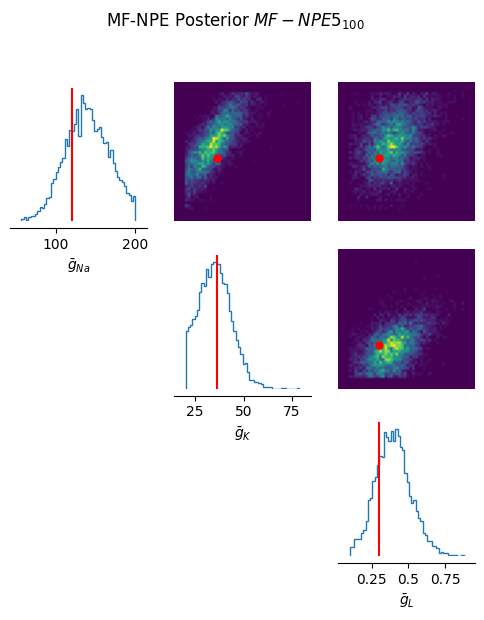

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
jax_key = jax.random.PRNGKey(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OBS_PATH = pathlib.Path("outputs/single_hf_trace/markov_ground_truth_trace.npz")
LF_PATH = pathlib.Path("outputs/mf_npe_5_100/training_data/lf_training_data_100000.pt")
HF_PATH = pathlib.Path("outputs/mf_npe_5_100/training_data/hf_training_data_100.pt")
SAVE_DIR = pathlib.Path("outputs/mf_npe_5_100")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR & SUMMARY
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

@jax.jit
def summarize_voltage_jax(t, V):
    crossings = jnp.sum((V[:-1] < 0) & (V[1:] >= 0))
    rest_mask = t < 10.0
    stim_mask = (t >= 10.0) & (t < 30.0)
    n_rest = jnp.sum(rest_mask)
    mean_rest = jnp.sum(V * rest_mask) / n_rest
    var_rest = jnp.sum((V**2) * rest_mask) / n_rest - mean_rest**2
    std_rest = jnp.sqrt(jnp.maximum(var_rest, 0.0))
    mean_stim = jnp.sum(V * stim_mask) / jnp.sum(stim_mask)
    return jnp.stack([crossings, mean_rest, std_rest, mean_stim])

@jax.jit
@jax.vmap
def simulate_lf_jax(key, th):
    t, V, *_ = hh_current_noise(key=key, gbar_Na=th[0], gbar_K=th[1], gbar_L=th[2])
    return summarize_voltage_jax(t, V)

# ----------------------------------------------------------------------------
# 2. LOAD LF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading LF data from", LF_PATH)
lf_dict = torch.load(LF_PATH, map_location=device)
theta_lf = lf_dict.get("theta_train", lf_dict.get("theta"))
x_lf = lf_dict.get("x_train", lf_dict.get("x"))
print(f"  LF: θ shape {tuple(theta_lf.shape)}, x shape {tuple(x_lf.shape)}")

# ----------------------------------------------------------------------------
# LOAD HF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)
theta_hf_t = hf_dict.get("theta_hf", hf_dict.get("theta"))
x_hf_t = hf_dict.get("x_hf", hf_dict.get("x"))
print(f"  HF: θ shape {tuple(theta_hf_t.shape)}, x shape {tuple(x_hf_t.shape)}")

# ----------------------------------------------------------------------------
# TRAIN LOW-FIDELITY SNPE
# ----------------------------------------------------------------------------
print("Training LF SNPE...")
inference_lf = SNPE(prior=prior, density_estimator="maf", device=device)
de_lf = inference_lf.append_simulations(theta_lf, x_lf)
density_estimator_lf = de_lf.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=512,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_lf = inference_lf.build_posterior(density_estimator_lf)
torch.save(posterior_lf, SAVE_DIR / "lf_de.pkl")
print("LF SNPE done.")

# ----------------------------------------------------------------------------
# TRAIN MULTI-FIDELITY SNPE (LF→HF) with ROBUST FINE-TUNING
# ----------------------------------------------------------------------------
print("Computing LF summaries at HF thetas via JAX...")
theta_hf_np = theta_hf_t.cpu().numpy()
key, jax_key = jax.random.split(jax_key)
hf_keys = jax.random.split(key, theta_hf_np.shape[0])
x_lf_at_hf = np.array(simulate_lf_jax(hf_keys, jnp.array(theta_hf_np)))
x_lf_at_hf_t = torch.from_numpy(x_lf_at_hf).float()

print("Setting up MF SNPE and transferring matching LF weights…")
inference_mf = SNPE(prior=prior, density_estimator="maf", device=device)
x_mf_t = torch.cat([x_lf_at_hf_t, x_hf_t], dim=1)
de_mf = inference_mf.append_simulations(theta_hf_t, x_mf_t)
density_estimator_mf = de_mf._build_neural_net(theta_hf_t, x_mf_t)
lf_state = density_estimator_lf.state_dict()
mf_state = density_estimator_mf.state_dict()
for k, v in lf_state.items():
    if k in mf_state and v.shape == mf_state[k].shape:
        mf_state[k] = v
density_estimator_mf.load_state_dict(mf_state)

print("Fine-tuning MF SNPE with early stopping and regularization...")
density_estimator_mf = de_mf.train(
    max_num_epochs=400,
    learning_rate=1e-4,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_mf = inference_mf.build_posterior(density_estimator_mf)
torch.save(posterior_mf, SAVE_DIR / "mf_de.pkl")
print("MF SNPE done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
t_obs = obs["t"]
V_obs = obs["V_hi"]
theta_true_np = obs["theta"]
x_obs_hf = torch.from_numpy(obs["summary"]).float().unsqueeze(0)

print("Computing LF summary for the observed data...")
obs_key, jax_key = jax.random.split(jax_key)
x_obs_lf_np = np.array(simulate_lf_jax(
    jnp.array([obs_key]),
    jnp.array([theta_true_np])
))
x_obs_lf = torch.from_numpy(x_obs_lf_np).float()
x_obs_mf = torch.cat([x_obs_lf, x_obs_hf], dim=1).to(device)
torch.save(x_obs_mf, SAVE_DIR / "x_obs_mf.pt")   
print(f"  Created and saved MF observation with shape: {x_obs_mf.shape}")

theta_true = torch.from_numpy(theta_true_np).float().to(device)

print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_mf.sample((5000,), x=x_obs_mf)

lp_true = posterior_mf.log_prob(theta_true.unsqueeze(0), x=x_obs_mf)
print(f"NLTP at truth: {-lp_true.item():.3f}")

means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_mf.log_prob(samples, x=x_obs_mf).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# 7. POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle("MF-NPE Posterior $MF-NPE5_{100}$", y=1.02)
fig.savefig(SAVE_DIR / "posterior_pairplot_5_100.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

## **$MF-NPE4_{100}$**

Loading LF data from mf_npe_demo/mf-npe4(100)/lf_training_data_10000.pt
  LF: θ shape (10000, 3), x shape (10000, 4)
Loading HF data from mf_npe_demo/mf-npe4(100)/hf_training_data_100.pt
  HF: θ shape (100, 3), x shape (100, 4)
Training LF SNPE...
 Training neural network. Epochs trained: 1

/tmp/ipykernel_3516969/2234994975.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_dict = torch.load(LF_PATH, map_location=device)
/tmp/ipykernel_3516969/2234994975.p

 Neural network successfully converged after 90 epochs.LF SNPE done.
Computing LF summaries at HF thetas via JAX...
Setting up MF SNPE and transferring matching LF weights…
Fine-tuning MF SNPE with early stopping and regularization...
 Training neural network. Epochs trained: 401MF SNPE done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
Computing LF summary for the observed data...
  Created MF observation with shape: torch.Size([1, 8])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5554it [00:00, 128101.69it/s]                   

NLTP at truth: 8.709
MAP: [110.31476    26.771906    0.5597714], mean: [116.91361   29.010925   0.555327], std: [22.206913    5.8329268   0.20467275]
Generating plots...



/tmp/ipykernel_3516969/2234994975.py:147: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.


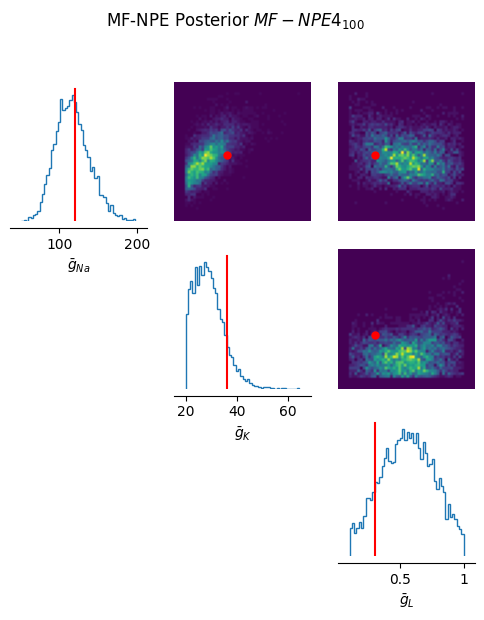

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
jax_key = jax.random.PRNGKey(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OBS_PATH = pathlib.Path("outputs/single_hf_trace/markov_ground_truth_trace.npz")
LF_PATH = pathlib.Path("outputs/mf_npe_4_100/training_data/lf_training_data_10000.pt")
HF_PATH = pathlib.Path("outputs/mf_npe_4_100/training_data/hf_training_data_100.pt")
SAVE_DIR = pathlib.Path("outputs/mf_npe_4_100")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR & SUMMARY
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

@jax.jit
def summarize_voltage_jax(t, V):
    crossings = jnp.sum((V[:-1] < 0) & (V[1:] >= 0))
    rest_mask = t < 10.0
    stim_mask = (t >= 10.0) & (t < 30.0)
    n_rest = jnp.sum(rest_mask)
    mean_rest = jnp.sum(V * rest_mask) / n_rest
    var_rest = jnp.sum((V**2) * rest_mask) / n_rest - mean_rest**2
    std_rest = jnp.sqrt(jnp.maximum(var_rest, 0.0))
    mean_stim = jnp.sum(V * stim_mask) / jnp.sum(stim_mask)
    return jnp.stack([crossings, mean_rest, std_rest, mean_stim])

@jax.jit
@jax.vmap
def simulate_lf_jax(key, th):
    t, V, *_ = hh_current_noise(key=key, gbar_Na=th[0], gbar_K=th[1], gbar_L=th[2])
    return summarize_voltage_jax(t, V)

# ----------------------------------------------------------------------------
# 2. LOAD LF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading LF data from", LF_PATH)
lf_dict = torch.load(LF_PATH, map_location=device)
theta_lf = lf_dict.get("theta_train", lf_dict.get("theta"))
x_lf = lf_dict.get("x_train", lf_dict.get("x"))
print(f"  LF: θ shape {tuple(theta_lf.shape)}, x shape {tuple(x_lf.shape)}")

# ----------------------------------------------------------------------------
# LOAD HF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)
theta_hf_t = hf_dict.get("theta_hf", hf_dict.get("theta"))
x_hf_t = hf_dict.get("x_hf", hf_dict.get("x"))
print(f"  HF: θ shape {tuple(theta_hf_t.shape)}, x shape {tuple(x_hf_t.shape)}")

# ----------------------------------------------------------------------------
# TRAIN LOW-FIDELITY SNPE
# ----------------------------------------------------------------------------
print("Training LF SNPE...")
inference_lf = SNPE(prior=prior, density_estimator="maf", device=device)
de_lf = inference_lf.append_simulations(theta_lf, x_lf)
density_estimator_lf = de_lf.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=512,
    validation_fraction=0.1,
    stop_after_epochs=20,
)
posterior_lf = inference_lf.build_posterior(density_estimator_lf)
torch.save(posterior_mf, SAVE_DIR / "lf_de_4_100.pkl")
print("LF SNPE done.")

# ----------------------------------------------------------------------------
# TRAIN MULTI-FIDELITY SNPE (LF→HF) with ROBUST FINE-TUNING
# ----------------------------------------------------------------------------
print("Computing LF summaries at HF thetas via JAX...")
theta_hf_np = theta_hf_t.cpu().numpy()
key, jax_key = jax.random.split(jax_key)
hf_keys = jax.random.split(key, theta_hf_np.shape[0])
x_lf_at_hf = np.array(simulate_lf_jax(hf_keys, jnp.array(theta_hf_np)))
x_lf_at_hf_t = torch.from_numpy(x_lf_at_hf).float()

print("Setting up MF SNPE and transferring matching LF weights…")
inference_mf = SNPE(prior=prior, density_estimator="maf", device=device)
x_mf_t = torch.cat([x_lf_at_hf_t, x_hf_t], dim=1)
de_mf = inference_mf.append_simulations(theta_hf_t, x_mf_t)
density_estimator_mf = de_mf._build_neural_net(theta_hf_t, x_mf_t)
lf_state = density_estimator_lf.state_dict()
mf_state = density_estimator_mf.state_dict()
for k, v in lf_state.items():
    if k in mf_state and v.shape == mf_state[k].shape:
        mf_state[k] = v
density_estimator_mf.load_state_dict(mf_state)

print("Fine-tuning MF SNPE with early stopping and regularization...")
density_estimator_mf = de_mf.train(
    max_num_epochs=400,
    learning_rate=1e-4,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_mf = inference_mf.build_posterior(density_estimator_mf)
torch.save(posterior_mf, SAVE_DIR / "mf_de_4_100.pkl")
print("MF SNPE done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
t_obs = obs["t"]
V_obs = obs["V_hi"]
theta_true_np = obs["theta"]
x_obs_hf = torch.from_numpy(obs["summary"]).float().unsqueeze(0)

print("Computing LF summary for the observed data...")
obs_key, jax_key = jax.random.split(jax_key)
x_obs_lf_np = np.array(simulate_lf_jax(jnp.array([obs_key]), jnp.array([theta_true_np])))
x_obs_lf = torch.from_numpy(x_obs_lf_np).float()

x_obs_mf = torch.cat([x_obs_lf, x_obs_hf], dim=1).to(device)
torch.save(x_obs_mf, SAVE_DIR / "x_obs_mf.pt")  
print(f"  Created MF observation with shape: {x_obs_mf.shape}")

theta_true = torch.from_numpy(theta_true_np).float().to(device)


print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_mf.sample((5000,), x=x_obs_mf)

lp_true = posterior_mf.log_prob(theta_true.unsqueeze(0), x=x_obs_mf)
print(f"NLTP at truth: {-lp_true.item():.3f}")

means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_mf.log_prob(samples, x=x_obs_mf).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle("MF-NPE Posterior $MF-NPE4_{100}$", y=1.02)
fig.savefig(SAVE_DIR / "posterior_pairplot_4_100.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

# 

## **$MF-NPE4_{1000}$**

Loading LF data from mf-npe_4_1000/lf_training_data_10000.pt
  LF: θ shape (10000, 3), x shape (10000, 4)
Loading HF data from mf-npe_4_1000/hf_training_data_1000.pt
  HF: θ shape (1000, 3), x shape (1000, 4)
Training LF SNPE...
 Training neural network. Epochs trained: 1

/tmp/ipykernel_3516969/3479345297.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_dict = torch.load(LF_PATH, map_location=device)
/tmp/ipykernel_3516969/3479345297.p

 Neural network successfully converged after 90 epochs.LF SNPE done.
Computing LF summaries at HF thetas via JAX...
Setting up MF SNPE and transferring matching LF weights…
Fine-tuning MF SNPE with early stopping and regularization...
 Neural network successfully converged after 239 epochs.MF SNPE done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
Computing LF summary for the observed data...
  Created MF observation with shape: torch.Size([1, 8])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5183it [00:00, 141971.34it/s]                   

NLTP at truth: 7.186
MAP: [136.81683    33.182053    0.3393756], mean: [138.47098    33.62474     0.3475522], std: [29.823847    6.3450136   0.09377898]
Generating plots...



/tmp/ipykernel_3516969/3479345297.py:147: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.


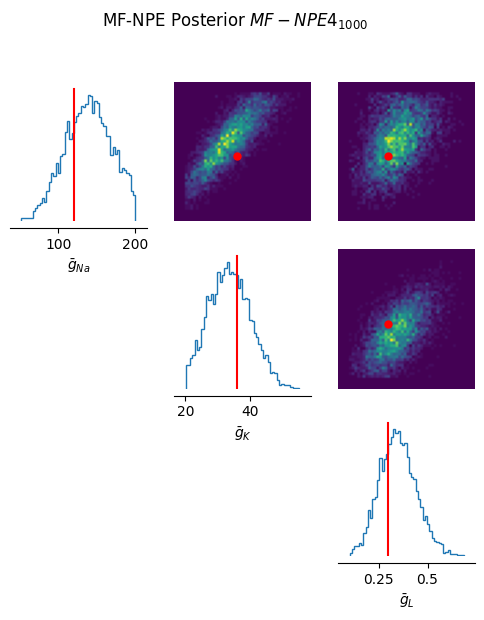

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
jax_key = jax.random.PRNGKey(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OBS_PATH = pathlib.Path("outputs/single_hf_trace/markov_ground_truth_trace.npz")
LF_PATH = pathlib.Path("outputs/mf_npe_4_1000/training_data/lf_training_data_10000.pt")
HF_PATH = pathlib.Path("outputs/mf_npe_4_1000/training_data/hf_training_data_1000.pt")
SAVE_DIR = pathlib.Path("outputs/mf_npe_4_1000")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR & SUMMARY
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

@jax.jit
def summarize_voltage_jax(t, V):
    crossings = jnp.sum((V[:-1] < 0) & (V[1:] >= 0))
    rest_mask = t < 10.0
    stim_mask = (t >= 10.0) & (t < 30.0)
    n_rest = jnp.sum(rest_mask)
    mean_rest = jnp.sum(V * rest_mask) / n_rest
    var_rest = jnp.sum((V**2) * rest_mask) / n_rest - mean_rest**2
    std_rest = jnp.sqrt(jnp.maximum(var_rest, 0.0))
    mean_stim = jnp.sum(V * stim_mask) / jnp.sum(stim_mask)
    return jnp.stack([crossings, mean_rest, std_rest, mean_stim])

@jax.jit
@jax.vmap
def simulate_lf_jax(key, th):
    t, V, *_ = hh_current_noise(key=key, gbar_Na=th[0], gbar_K=th[1], gbar_L=th[2])
    return summarize_voltage_jax(t, V)

# ----------------------------------------------------------------------------
# LOAD LF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading LF data from", LF_PATH)
lf_dict = torch.load(LF_PATH, map_location=device)
theta_lf = lf_dict.get("theta_train", lf_dict.get("theta"))
x_lf = lf_dict.get("x_train", lf_dict.get("x"))
print(f"  LF: θ shape {tuple(theta_lf.shape)}, x shape {tuple(x_lf.shape)}")

# ----------------------------------------------------------------------------
# LOAD HF TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)
theta_hf_t = hf_dict.get("theta_hf", hf_dict.get("theta"))
x_hf_t = hf_dict.get("x_hf", hf_dict.get("x"))
print(f"  HF: θ shape {tuple(theta_hf_t.shape)}, x shape {tuple(x_hf_t.shape)}")

# ----------------------------------------------------------------------------
# TRAIN LOW-FIDELITY SNPE
# ----------------------------------------------------------------------------
print("Training LF SNPE...")
inference_lf = SNPE(prior=prior, density_estimator="maf", device=device)
de_lf = inference_lf.append_simulations(theta_lf, x_lf)
density_estimator_lf = de_lf.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=512,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_lf = inference_lf.build_posterior(density_estimator_lf)
torch.save(posterior_mf, SAVE_DIR / "lf_de_4_1000.pkl")
print("LF SNPE done.")

# ----------------------------------------------------------------------------
# TRAIN MULTI-FIDELITY SNPE (LF→HF) with ROBUST FINE-TUNING
# ----------------------------------------------------------------------------
print("Computing LF summaries at HF thetas via JAX...")
theta_hf_np = theta_hf_t.cpu().numpy()
key, jax_key = jax.random.split(jax_key)
hf_keys = jax.random.split(key, theta_hf_np.shape[0])
x_lf_at_hf = np.array(simulate_lf_jax(hf_keys, jnp.array(theta_hf_np)))
x_lf_at_hf_t = torch.from_numpy(x_lf_at_hf).float()

print("Setting up MF SNPE and transferring matching LF weights…")
inference_mf = SNPE(prior=prior, density_estimator="maf", device=device)
x_mf_t = torch.cat([x_lf_at_hf_t, x_hf_t], dim=1)
de_mf = inference_mf.append_simulations(theta_hf_t, x_mf_t)
density_estimator_mf = de_mf._build_neural_net(theta_hf_t, x_mf_t)
lf_state = density_estimator_lf.state_dict()
mf_state = density_estimator_mf.state_dict()
for k, v in lf_state.items():
    if k in mf_state and v.shape == mf_state[k].shape:
        mf_state[k] = v
density_estimator_mf.load_state_dict(mf_state)

print("Fine-tuning MF SNPE with early stopping and regularization...")
density_estimator_mf = de_mf.train(
    max_num_epochs=400,
    learning_rate=1e-4,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_mf = inference_mf.build_posterior(density_estimator_mf)
torch.save(posterior_mf, SAVE_DIR / "mf_de_4_1000.pkl")
print("MF SNPE done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
t_obs = obs["t"]
V_obs = obs["V_hi"]
theta_true_np = obs["theta"]
x_obs_hf = torch.from_numpy(obs["summary"]).float().unsqueeze(0)

print("Computing LF summary for the observed data...")
obs_key, jax_key = jax.random.split(jax_key)
x_obs_lf_np = np.array(simulate_lf_jax(jnp.array([obs_key]), jnp.array([theta_true_np])))
x_obs_lf = torch.from_numpy(x_obs_lf_np).float()

x_obs_mf = torch.cat([x_obs_lf, x_obs_hf], dim=1).to(device)
torch.save(x_obs_mf, SAVE_DIR / "x_obs_mf.pt")  
print(f"  Created MF observation with shape: {x_obs_mf.shape}")

theta_true = torch.from_numpy(theta_true_np).float().to(device)


print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_mf.sample((5000,), x=x_obs_mf)

lp_true = posterior_mf.log_prob(theta_true.unsqueeze(0), x=x_obs_mf)
print(f"NLTP at truth: {-lp_true.item():.3f}")

means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_mf.log_prob(samples, x=x_obs_mf).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle("MF-NPE Posterior $MF-NPE4_{1000}$", y=1.02)
fig.savefig(SAVE_DIR / "posterior_pairplot_4_1000.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

## **$NPE_{100}$**

Loading HF data from hf_training_data/hf_training_data.pt
  HF: θ shape (100, 3), x shape (100, 4)
Training standard NPE on HF data...
 Training neural network. Epochs trained: 20

/tmp/ipykernel_3516969/238510217.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_dict = torch.load(HF_PATH, map_location=device)


 Neural network successfully converged after 38 epochs.NPE training done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
  Using HF observation with shape: torch.Size([1, 4])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5533it [00:00, 205221.69it/s]                   

NLTP at truth: 9.387
MAP: [109.82355     59.75557      0.55405074], mean: [118.766014   61.2276      0.5455273], std: [35.94622   17.687391   0.1880274]
Generating plots...



/tmp/ipykernel_3516969/238510217.py:98: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.

--- NPE baseline script finished successfully. ---


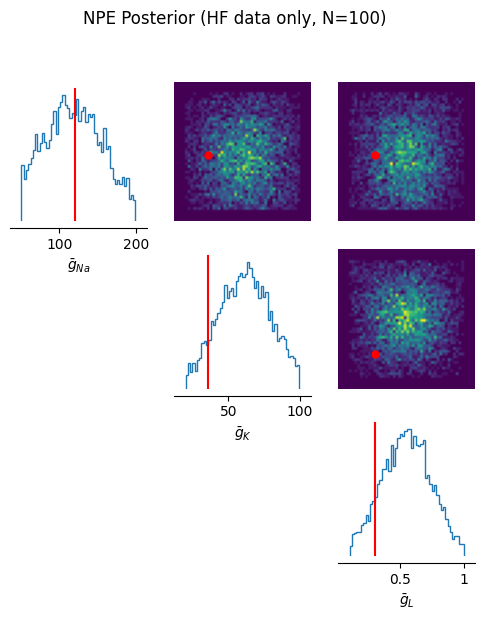

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HF_PATH = pathlib.Path("outputs/hf_training_data/hf_training_data_100.pt")
OBS_PATH = pathlib.Path("outputs/hf_trace/markov_ground_truth_trace.npz")
SAVE_DIR = pathlib.Path("outputs/npe_100")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

# ----------------------------------------------------------------------------
# LOAD HIGH-FIDELITY TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)

theta_hf = hf_dict['theta_train']
x_hf = hf_dict['x_train']

print(f"  HF: θ shape {tuple(theta_hf.shape)}, x shape {tuple(x_hf.shape)}")

# ----------------------------------------------------------------------------
# TRAIN STANDARD HIGH-FIDELITY NPE
# ----------------------------------------------------------------------------
print("Training standard NPE on HF data...")
inference_npe = SNPE(prior=prior, density_estimator="maf", device=device)

de_npe = inference_npe.append_simulations(theta_hf, x_hf)

# Train the density estimator
density_estimator_npe = de_npe.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_npe = inference_npe.build_posterior(density_estimator_npe)

# Save the model with a name reflecting the number of simulations
num_sims = theta_hf.shape[0]
torch.save(posterior_npe, SAVE_DIR / f"npe_de_{num_sims}.pkl")
print("NPE training done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
theta_true_np = obs["theta"]
x_obs = torch.from_numpy(obs["summary"]).float().unsqueeze(0).to(device)

torch.save(x_obs, SAVE_DIR / "x_obs.pt")  
print(f"  Using HF observation with shape: {x_obs.shape}")
theta_true = torch.from_numpy(theta_true_np).float().to(device)

print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_npe.sample((5000,), x=x_obs)


# Evaluate the Negative Log-Probability of the True parameters
lp_true = posterior_npe.log_prob(theta_true.unsqueeze(0), x=x_obs)
print(f"NLTP at truth: {-lp_true.item():.3f}")

# Calculate MAP estimate and other stats
means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_npe.log_prob(samples, x=x_obs).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle(f"NPE Posterior (HF data only, N={num_sims})", y=1.02)
fig.savefig(SAVE_DIR / f"posterior_pairplot_npe_{num_sims}.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

print("\n--- NPE baseline script finished successfully. ---")

## **$NPE_{1000}$**

Loading HF data from hf_training_data/hf_training_data_100.pt
  HF: θ shape (1000, 3), x shape (1000, 4)
Training standard NPE on HF data...
 Training neural network. Epochs trained: 1

/tmp/ipykernel_3516969/1670895242.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_dict = torch.load(HF_PATH, map_location=device)


 Neural network successfully converged after 36 epochs.NPE training done.
Loading observed HF data from hf_trace/markov_ground_truth_trace.npz
  Using HF observation with shape: torch.Size([1, 4])
Sampling from posterior and evaluating...


Drawing 5000 posterior samples: 5444it [00:00, 195677.40it/s]                   

NLTP at truth: 8.959
MAP: [126.564575   56.177002    0.5636058], mean: [124.02553     57.884518     0.55801386], std: [34.51995    17.75605     0.20786227]
Generating plots...



/tmp/ipykernel_3516969/1670895242.py:97: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_legend'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


Saved pairplot.

--- NPE baseline script finished successfully. ---


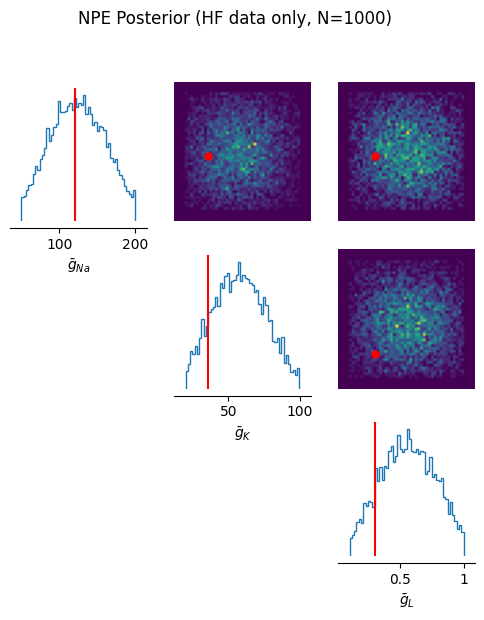

In [ ]:
# ----------------------------------------------------------------------------
# SETTINGS & PATHS
# ----------------------------------------------------------------------------
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HF_PATH = pathlib.Path("outputs/hf_training_data/hf_training_data_1000.pt")
OBS_PATH = pathlib.Path("outputs/hf_trace/markov_ground_truth_trace.npz")
SAVE_DIR = pathlib.Path("outputs/npe_1000")
SAVE_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------------
# PRIOR
# ----------------------------------------------------------------------------
prior = BoxUniform(low=torch.tensor([50.0, 20.0, 0.1]), high=torch.tensor([200.0, 100.0, 1.0]))

# ----------------------------------------------------------------------------
# LOAD HIGH-FIDELITY TRAINING DATA
# ----------------------------------------------------------------------------
print("Loading HF data from", HF_PATH)
hf_dict = torch.load(HF_PATH, map_location=device)

theta_hf = hf_dict['theta_train']
x_hf = hf_dict['x_train']

print(f"  HF: θ shape {tuple(theta_hf.shape)}, x shape {tuple(x_hf.shape)}")

# ----------------------------------------------------------------------------
# TRAIN STANDARD HIGH-FIDELITY NPE
# ----------------------------------------------------------------------------
print("Training standard NPE on HF data...")
inference_npe = SNPE(prior=prior, density_estimator="maf", device=device)

de_npe = inference_npe.append_simulations(theta_hf, x_hf)

density_estimator_npe = de_npe.train(
    max_num_epochs=400,
    learning_rate=1e-3,
    training_batch_size=32,
    validation_fraction=0.1,
    stop_after_epochs=20)
posterior_npe = inference_npe.build_posterior(density_estimator_npe)

# Save the model with a name reflecting the number of simulations
num_sims = theta_hf.shape[0]
torch.save(posterior_npe, SAVE_DIR / f"npe_de_{num_sims}.pkl")
print("NPE training done.")

# ----------------------------------------------------------------------------
# INFERENCE & EVALUATION
# ----------------------------------------------------------------------------
print("Loading observed HF data from", OBS_PATH)
obs = np.load(OBS_PATH)
theta_true_np = obs["theta"]
x_obs = torch.from_numpy(obs["summary"]).float().unsqueeze(0).to(device)

torch.save(x_obs, SAVE_DIR / "x_obs.pt") 
print(f"  Using HF observation with shape: {x_obs.shape}")
theta_true = torch.from_numpy(theta_true_np).float().to(device)

print("Sampling from posterior and evaluating...")
with torch.no_grad():
    samples = posterior_npe.sample((5000,), x=x_obs)

# Evaluate the Negative Log-Probability of the True parameters
lp_true = posterior_npe.log_prob(theta_true.unsqueeze(0), x=x_obs)
print(f"NLTP at truth: {-lp_true.item():.3f}")

# Calculate MAP estimate and other stats
means = samples.mean(0).cpu().numpy()
stds = samples.std(0).cpu().numpy()
map_idx = posterior_npe.log_prob(samples, x=x_obs).argmax()
theta_map = samples[map_idx].cpu().numpy()
print(f"MAP: {theta_map}, mean: {means}, std: {stds}")

# ----------------------------------------------------------------------------
# POSTERIOR PAIRPLOT
# ----------------------------------------------------------------------------
print("Generating plots...")
fig, axes = pairplot(
    samples.cpu().numpy(),
    points=theta_true.cpu().numpy()[None, :],
    points_colors=["red"],
    labels=[r"$\bar{g}_{Na}$", r"$\bar{g}_{K}$", r"$\bar{g}_{L}$"],
    points_legend=["Ground Truth"],
    figsize=(6, 6)
)
fig.suptitle(f"NPE Posterior (HF data only, N={num_sims})", y=1.02)
fig.savefig(SAVE_DIR / f"posterior_pairplot_npe_{num_sims}.png", dpi=300, bbox_inches="tight")
print("Saved pairplot.")

print("\n--- NPE baseline script finished successfully. ---")